In [2]:
!ls ../data -hal

total 47M
drwxrwxr-x   4 kyle kyle 4.0K  5월  6 21:11 .
drwxrwxr-x   9 kyle kyle 4.0K  4월 18 20:23 ..
drwxrwxr-x   2 kyle kyle 4.0K  4월  4 22:53 .ipynb_checkpoints
-rw-rw-r--   1 kyle kyle    0  5월  6 21:11 crypto_currency-1.pickle
-rw-rw-r--   1 kyle kyle  46M  5월  6 21:12 crypto_currency.pickle
-rw-rw-r--   1 kyle kyle 1.5M  4월  8 18:02 crypto_currency_oot.pickle
drwxrwxr-x 444 kyle kyle  20K  4월  5 22:04 google-research


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pickle

with open('../data/crypto_currency.pickle', 'rb') as f:
    data = pickle.load(f)

In [27]:
coin = data['KRW-BTC'][['candle_date_time_kst', 'trade_price']]

In [28]:
type(coin)

pandas.core.frame.DataFrame

In [29]:
coin.dtypes

candle_date_time_kst     object
trade_price             float64
dtype: object

In [30]:
coin.set_index(pd.to_datetime(coin['candle_date_time_kst']), inplace = True)

In [31]:
coin.head()

,candle_date_time_kst,trade_price
candle_date_time_kst,,
2017-09-25 09:00:00,2017-09-25T09:00:00,4322000.0
2017-09-26 09:00:00,2017-09-26T09:00:00,4321000.0
2017-09-27 09:00:00,2017-09-27T09:00:00,4657000.0
2017-09-28 09:00:00,2017-09-28T09:00:00,4586000.0
2017-09-29 09:00:00,2017-09-29T09:00:00,4657000.0


In [32]:
coin.drop(columns = 'candle_date_time_kst', axis = 1, inplace = True)

In [33]:
coin = coin[~coin.index.duplicated(keep = 'first')]

In [34]:
coin.shape

(1618, 1)

In [40]:
series = TimeSeries.from_dataframe(
    coin, 
    value_cols = 'trade_price',
    fill_missing_value = True,
    freq = 'D'
)

In [54]:
len(series.shift(1)[1:])

1617

In [51]:
len(series.diff())

1617

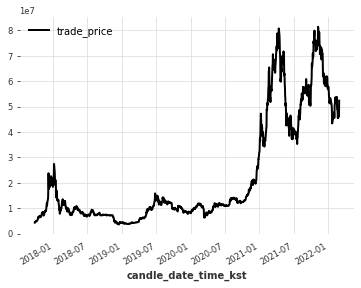

In [58]:
series.plot()

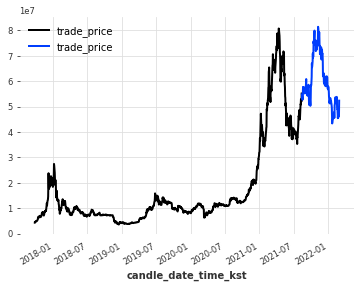

In [64]:
series1, series2 = series.split_before(pd.Timestamp('20210815'))
series1.plot()
series2.plot()

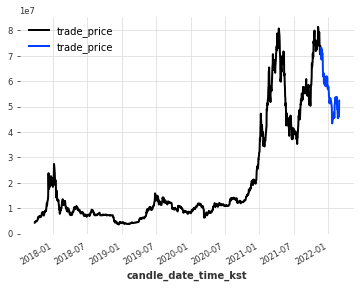

In [66]:
series1, series2 = series[:-100], series[-100:]
series1.plot()
series2.plot()

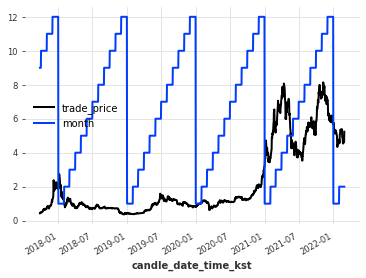

In [68]:
(series / 1e7).add_datetime_attribute('month').plot()

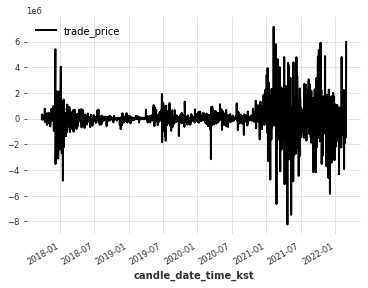

In [69]:
series.diff().plot()

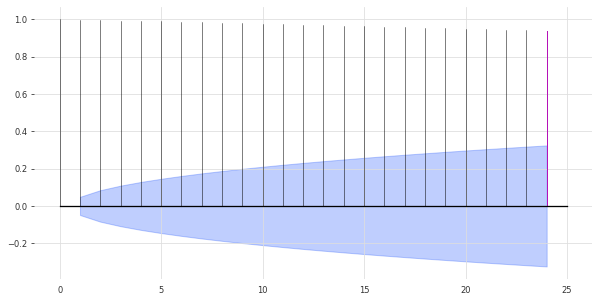

In [70]:
from darts.utils.statistics import plot_acf
plot_acf(series, m = 24, alpha = .05)

In [72]:
from darts.models import NaiveSeasonal



In [74]:
train, val = series[:-300], series[-300:]

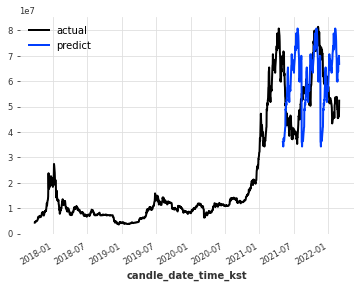

In [78]:
seasonal_model = NaiveSeasonal(K = 100)
seasonal_model.fit(train)
naive_forecast = seasonal_model.predict(300)
series.plot(label = 'actual')
naive_forecast.plot(label = 'predict')

### N-BEATS

In [79]:
# Create training and validation sets:
training_cutoff = pd.Timestamp("20220101")
train, val = series.split_after(training_cutoff)

In [81]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
from darts.dataprocessing.transformers import Scaler

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [82]:
from darts.models import NBEATSModel

input_chunk_length = 24
output_chunk_length=7

my_model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_BTC",
)

In [83]:
my_model.fit(
    train_transformed,
    val_series = val_transformed,
    verbose = True
)

[2022-05-07 11:47:47,457] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1530 samples.
[2022-05-07 11:47:47,457] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1530 samples.
2022-05-07 11:47:47 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1530 samples.
[2022-05-07 11:47:47,561] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-05-07 11:47:47,561] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-05-07 11:47:47 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-05-07 11:47:47,564] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Light

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [87]:
from darts.metrics import mape, r2_score
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        f'''R2: {r2_score(ts_transformed.univariate_component(0), pred_series)} \n
         mape: {mape(ts_transformed.univariate_component(0), pred_series)}'''
    )
    plt.legend()

  0%|          | 0/19 [00:00<?, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

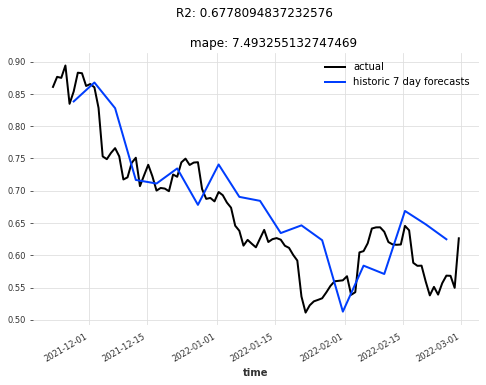

In [88]:
pred_series = my_model.historical_forecasts(
    series_transformed,
    start=series_transformed._time_index[-100],
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)
display_forecast(pred_series, series_transformed, "7 day", start_date=series_transformed._time_index[-100])